# Montreal-Python 2018 tutorial

In [1]:
from theano import function, tensor as tt
import pymc3 as pm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = tt.dmatrix('x')
s = tt.sum(1 / (1 + tt.exp(-x)))
gs = tt.grad(s, x)
dlogistic = function([x], gs)

dlogistic([[3, -1], [0, 2]])

array([[0.04517666, 0.19661193],
       [0.25      , 0.10499359]])

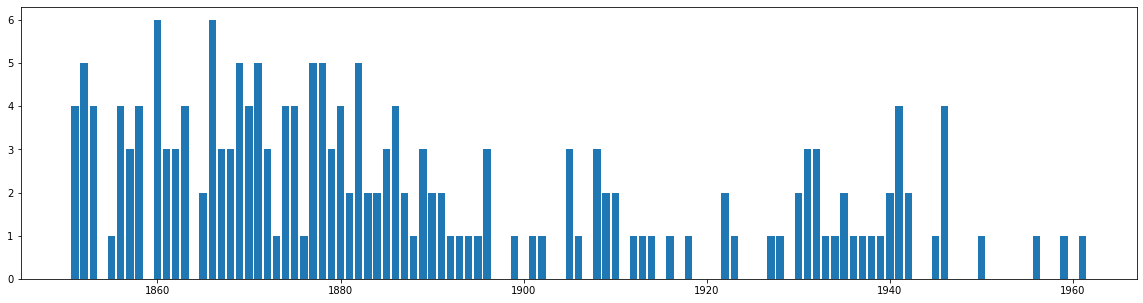

In [8]:
disasters_data = np.array([
    4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1
    , 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1
])

year = np.arange(1851, 1962)

plt.figure(figsize=(20, 5))
plt.bar(year, disasters_data)
plt.show()

__Model__

early_rate ~ Exponential(1)

late_rate ~ Exponential(1

switchpoint ~ Uniform(1851, 1962)

In [10]:
with pm.Model() as disaster_model:
    switch_point = pm.Uniform('switchpoint', lower=year.min(), upper=year.max())
    
    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

In [11]:
type(early_rate)

pymc3.model.TransformedRV

In [12]:
early_rate.distribution.logp(2.1).eval()

array(-2.1)

In [13]:
early_rate.random(size=4)

array([1.14228442, 1.22439129, 0.23134392, 0.37212195])

__Switch point logic__

rate = early_mean if t < switchpoint else late_mean

In [15]:
with disaster_model:
    rate = pm.math.switch(switch_point >= year, early_rate, late_rate)

__Likelihood__

number of disasters ~ Poisson(rate)

In [16]:
with disaster_model:
    n_disasters = pm.Poisson('n_disasters', rate, observed=disasters_data)

## MCMC

In [18]:
with disaster_model:
    samples = pm.sample(draws=1000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [late_rate, early_rate, switchpoint]
Sampling 4 chains: 100%|██████████| 24000/24000 [10:11<00:00, 39.23draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


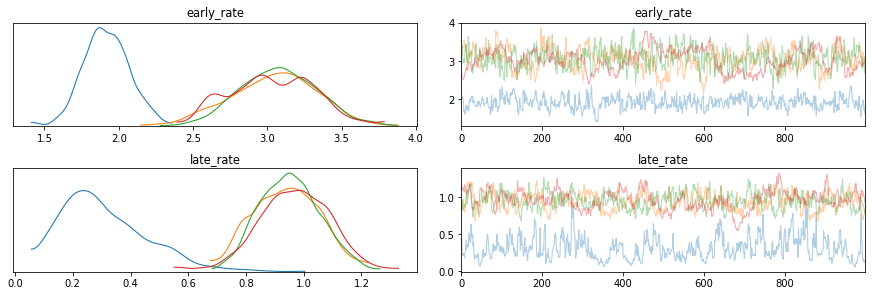

In [20]:
pm.plots.traceplot(samples, var_names=['early_rate', 'late_rate'])
plt.show()

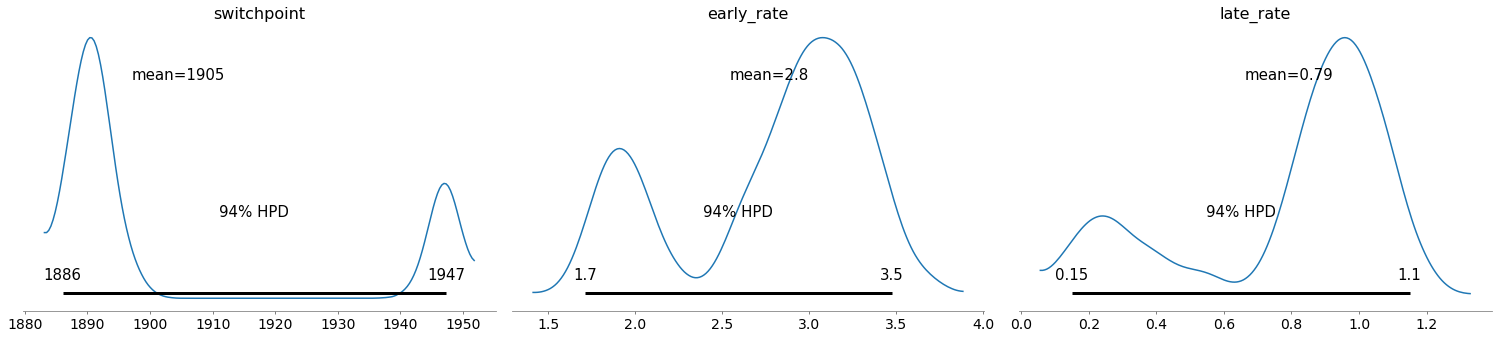

In [21]:
pm.plot_posterior(samples)
plt.show()

# PyCon 2018    

$k(x, x') = \eta ~ \text{exp} \left[ -\frac{(x - x')^2}{2 \rho^2} \right]$

In [2]:
with pm.Model() as salmon_model:
    rho = pm.HalfCauchy('rho', 3)  # lengthscale
    eta = pm.HalfCauchy('eta', 3)  # signal variance

In [3]:
with salmon_model:
    M = pm.gp.mean.Linear(coeffs=(y / X).mean())
    K = eta * pm.gp.cov.ExpQuad(1, rho)
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)

NameError: name 'y' is not defined

In [ ]:
with salmon_model:
    sigma = pm.HalfNormal('sigma', 1)
    recruits = pm.gp.marginal_likelihood(
        'recruits',
        X=X, y=y, noise=sigma
    )

In [ ]:
with salmon_model:
    fit = pm.find_MAP()

In [ ]:
spawner_range = np.linspace(0, 500, 100).reshape(-1, 1)

with salmon_model:
    salmon_pred = pm.gp.conditional(
        'salmon_pred',
        spanwer_range,
        pred_noise=False  # will be turned on at the next step
    )
    salmon_samples = pm.sample_ppc(
        [fit],
        vars=[salmon_pred],
        samples=3
    )

In [ ]:
spawner_range = np.linspace(0, 500, 100).reshape(-1, 1)

with salmon_model:
    salmon_pred = pm.gp.conditional(
        'salmon_pred',
        spanwer_range,
        pred_noise=True
    )
    salmon_samples = pm.sample_ppc(
        [fit],
        vars=[salmon_pred],
        samples=3
    )